# EX 3 using TF

## Set up

In [1]:
# install packages
# !pip install jiwer
# !pip install pandas
# !pip install matplotlib
# !pip install sentence-


In [40]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import time

import torch
device = torch.device("cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from sentence_transformers import SentenceTransformer, util
minilm = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


%matplotlib inline

cpu


## Data Prep
### Load Data

In [3]:
data_path = "/home/slimlab/Downloads/LJSpeech-1.1"
wavs_path = data_path + "/16khz/wavs/"
metadata_path = data_path + "/metadata.csv"

# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ036-0119,Whaley displayed a trip manifest which showed ...
1,LJ049-0034,could have reached the President in time to pr...
2,LJ024-0008,That plan has two chief purposes.


### Split Data

In [4]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


### Character ↔️ Number Function

In [5]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [6]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Data encoding function
takes in a pice of audio and a trancript and outputs a spectrogram of the audio with the encoded transcript

In [7]:
from tensorflow.python.ops.gen_spectral_ops import fft
# int. scalar tensor. window length in samples
frame_length = 256
# int. scalar tensor. number of samples to step
frame_step = 160
# int scalar tensor. size of FFT
fft_length = 384

def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")

    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float, this step might not be necessary
    audio = tf.cast(audio, tf.float32)

    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, 
        frame_length=frame_length, 
        frame_step=frame_step, 
        fft_length=fft_length
    )

    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)

    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")

    # 9. Map the characters in label to numbers
    label = char_to_num(label)

    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [8]:
encode_single_sample(metadata_df.file_name[0], metadata_df.normalized_transcription[0])


(<tf.Tensor: shape=(825, 193), dtype=float32, numpy=
 array([[ 1.3485438 ,  2.1308708 ,  3.1170154 , ..., -0.5602474 ,
         -0.5220045 , -0.53608775],
        [-0.16206759, -0.06853716,  0.25135645, ..., -0.43513924,
         -0.42617866, -0.42320365],
        [-0.31850922, -0.20089221, -0.06277089, ..., -0.47842014,
         -0.49367356, -0.51668215],
        ...,
        [-0.22045694,  0.14662713,  1.7903873 , ..., -0.6035865 ,
         -0.77910453, -0.9537302 ],
        [ 0.01573325,  0.07926735,  1.205678  , ..., -0.9859077 ,
         -1.0692526 , -1.1656872 ],
        [-0.7024708 ,  0.10010318,  1.0467992 , ..., -0.9387688 ,
         -0.75672114, -0.6142446 ]], dtype=float32)>,
 <tf.Tensor: shape=(117,), dtype=int64, numpy=
 array([23,  8,  1, 12,  5, 25, 30,  4,  9, 19, 16, 12,  1, 25,  5,  4, 30,
         1, 30, 20, 18,  9, 16, 30, 13,  1, 14,  9,  6,  5, 19, 20, 30, 23,
         8,  9,  3,  8, 30, 19,  8, 15, 23,  5,  4, 30,  1, 30, 20, 23,  5,
        12, 22,  5, 30, 15, 2

### Create dataset objects

In [9]:
batch_size = 16

# define training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

### Checkout one sample

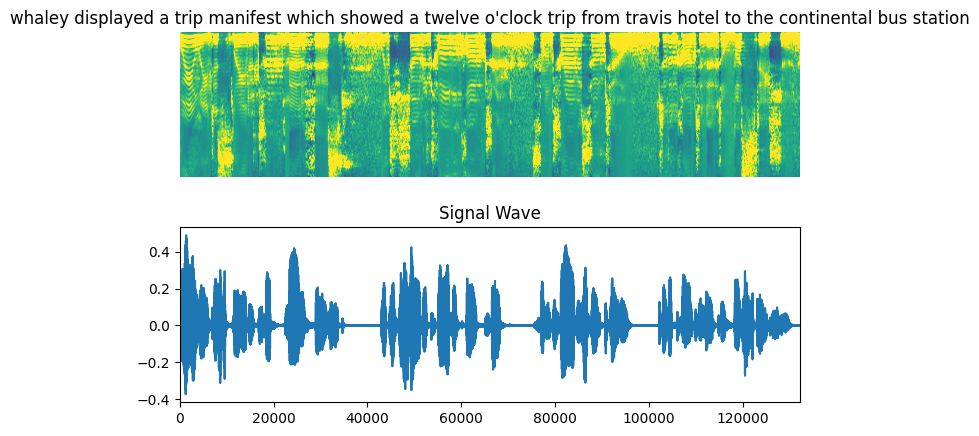

In [10]:
fig = plt.figure(figsize=(8,5))

for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))

plt.show()

## Functions

In [11]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


In [12]:
# embeds and calculates cosine similarity
# returns matrix of all cosine similaritys
# between s and s1
def get_cos_sim(s, s1, model=minilm):
    embedding_s = model.encode(s, convert_to_tensor=True)
    embedding_s1 = model.encode(s1, convert_to_tensor=True)
    return util.pytorch_cos_sim(embedding_s, embedding_s1)


# get the diagonals of the cosine matrix
def get_respective_cos_sim(s, s1, model=minilm):
    cos_sim = get_cos_sim(s, s1, model)
    return cos_sim.diagonal()

# smoothing relu so that there will never be
# log of negative number or 0
def relu(x):
    return torch.max(torch.tensor(0.0000001),x)

# custom cosine loss
# the negative log of the cosine similarity
def get_cos_loss(s, s1, model=minilm):
    cos_sim = get_respective_cos_sim(s, s1, model)
    # remove negatives and look at neg loglikilood
    cos_sim = relu(cos_sim).reshape((len(s),1))
    return -np.log(cos_sim.cpu()).numpy()

# decodes set of label
def get_labels(y):
    gt = []
    for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        gt.append(label)
    return gt

In [13]:
# Normal CTCLoss function
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [14]:
def CTC_Cosine_Loss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    y_true_labs = get_labels(y_true)
    # print(y_true_labs)
    y_pred_labs = decode_batch_predictions(y_pred)
    # print(y_pred_labs)
    cos_loss = get_cos_loss(y_true_labs, y_pred_labs)
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    # print(cos_loss)
    return loss + cos_loss

## Model

In [15]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128, loss=CTCLoss):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.legacy.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=loss, run_eagerly=True)
#     model.compile(optimizer=opt, loss=loss)
    
    return model




In [ ]:
model_base = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
    loss=CTCLoss,
)

In [16]:
model_cos = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=128,
    loss=CTC_Cosine_Loss,
    
)

In [ ]:
model_cos.summary()

In [ ]:
# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        avg_cos_dis = get_cos_loss(targets, predictions).mean()
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print(f"Avg. Cos Loss: {avg_cos_dis:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print(f"Word Error Rate For Example: {wer(targets[i], predictions[i]):.4f}")
            print(f"Avg. Cos Loss: {get_cos_loss(targets[i], predictions[i]):.4f}")
            print("-" * 100)
            
            

## Training

In [ ]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history_base = model_base.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

In [ ]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history_cos = model_cos.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model_base.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
    break
wer_score = wer(targets, predictions)
avg_cos_dis = get_cos_loss(targets, predictions).mean()
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Avg. Cos Loss: {avg_cos_dis:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print(f"Word Error Rate For Example: {wer(targets[i], predictions[i]):.4f}")
    print(f"Avg. Cos Loss: {get_cos_loss(targets[i], predictions[i]):.4f}")
    print("-" * 100)


## Testing

In [17]:
# gt = []
# for X, y in train_dataset:
#     for label in y:
#         label = (
#             tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
#         )
#         gt.append(label)
#     break
# gt

["whaley displayed a trip manifest which showed a twelve o'clock trip from travis hotel to the continental bus station",
 'could have reached the president in time to protect him from the second and fatal shot to hit the president',
 'that plan has two chief purposes',
 'looking over her right shoulder she saw that the president had both hands at his neck but she observed no blood and heard nothing',
 'with these differences were others as opposed concerning industrial occupation',
 'his extensive business had been carried on by fraud',
 'at the request of the commission arthur mandella',
 'dr smethurst was long an inmate of newgate and was tried at the central criminal court',
 'third because it will provide a series of federal courts willing to enforce the constitution as written',
 'at this stage it breathes equally by lungs and by gills  ie both air and water',
 "perhaps the tales that travelers told him were exaggerated as travelers' tales are likely to be",
 'claimed that about f

In [24]:
# batch_predictions = model_cos.predict(X)
# batch_predictions_decoded = decode_batch_predictions(batch_predictions)
# batch_predictions_decoded

1/1 [==============================] - 0s 181ms/step


[' ', '', '', '', 'w', 'ww', '', 'w', 'w', 'kw', 'w', 'w', 's', '', 'sw', 'q']

In [19]:
# get_labels(y)

["whaley displayed a trip manifest which showed a twelve o'clock trip from travis hotel to the continental bus station",
 'could have reached the president in time to protect him from the second and fatal shot to hit the president',
 'that plan has two chief purposes',
 'looking over her right shoulder she saw that the president had both hands at his neck but she observed no blood and heard nothing',
 'with these differences were others as opposed concerning industrial occupation',
 'his extensive business had been carried on by fraud',
 'at the request of the commission arthur mandella',
 'dr smethurst was long an inmate of newgate and was tried at the central criminal court',
 'third because it will provide a series of federal courts willing to enforce the constitution as written',
 'at this stage it breathes equally by lungs and by gills  ie both air and water',
 "perhaps the tales that travelers told him were exaggerated as travelers' tales are likely to be",
 'claimed that about f

In [ ]:
# get_cos_sim(gt, batch_predictions_decoded)


In [20]:
# CTCLoss(y, batch_predictions)

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[1089.896 ],
       [1095.3872],
       [1152.3423],
       [1083.9739],
       [1118.0807],
       [1138.039 ],
       [1139.2972],
       [1106.4514],
       [1098.1035],
       [1108.0448],
       [1101.6794],
       [1094.1327],
       [1096.4562],
       [1090.8009],
       [1132.2222],
       [1123.1895]], dtype=float32)>

In [ ]:
# CTC_Cosine_Loss(y, batch_predictions)

In [21]:
# with tf.GradientTape() as tape:
#     # Forward pass
#     y_pred = model_cos(X)
#     loss = CTC_Cosine_Loss(y, y_pred)

# # Calculate gradients with respect to every trainable variable
# grad = tape.gradient(loss, model_cos.trainable_variables)

# model_cos.optimizer.apply_gradients(
#     zip(grad, model_cos.trainable_weights)
# )


<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [22]:
# loss

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[1092.8237],
       [1111.5052],
       [1155.1025],
       [1100.0919],
       [1134.1987],
       [1140.7117],
       [1141.2719],
       [1109.0896],
       [1100.785 ],
       [1124.1628],
       [1104.6791],
       [1098.0823],
       [1100.6655],
       [1096.3267],
       [1133.9452],
       [1139.3075]], dtype=float32)>

In [23]:
# model_cos.test_step(X)['loss']

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [39]:
# epochs = 20
# for epoch in range(epochs):
#     print("\nStart of epoch %d" % (epoch,))
#     for step, (X,y) in enumerate(train_dataset):
#         with tf.GradientTape() as tape:
#             # Forward pass
#             y_pred = model_cos(X)
#             loss = CTC_Cosine_Loss(y, y_pred)

#             # Calculate gradients with respect to every trainable variable
#             grad = tape.gradient(loss, model_cos.trainable_variables)

#             model_cos.optimizer.apply_gradients(
#                 zip(grad, model_cos.trainable_weights)
#             )

#             if step == 0:
#                 batch_predictions = model_cos.predict(X)
#                 batch_predictions = decode_batch_predictions(batch_predictions)
#                 targets = get_labels(y)
#                 wer_score = wer(targets, batch_predictions)
#                 avg_cos_dis = get_cos_loss(targets, batch_predictions).mean()
#                 print("-" * 100)
#                 print(f"Word Error Rate: {wer_score:.4f}")
#                 print(f"Loss: {loss.numpy().mean():.4f}")
#                 print(f"Avg. Cos Loss: {avg_cos_dis:.4f}")
#                 print("-" * 100)
#                 for i in np.random.randint(0, len(batch_predictions), 2):
#                     print(f"Target    : {targets[i]}")
#                     print(f"Prediction: {batch_predictions[i]}")
#                     print(f"Word Error Rate For Example: {wer(targets[i], batch_predictions[i]):.4f}")
#                     print(f"Avg. Cos Loss: {get_cos_sim(targets[i], batch_predictions[i]).item():.4f}")
#                     print("-" * 100)
#         break

In [33]:
# get_cos_sim('at this stage it breathes equally by lungs and by gills  ie both air and water','')

In [ ]:
model_cos.save('cosine_penaltiy_20epochs')


In [ ]:
model_cos.save_weights('cos_weights_20epochs')

In [ ]:

def train(model, epochs, loss=CTC_Cosine_Loss name='model'):
    hist = {
        'train_wer': [],
        'train_cos_loss': [],
        
        'val_wer': [],        
        'val__cos_loss': [],
    }
    
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()
        
        for step, (X,y) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                # Forward pass
                y_pred = model(X)
                loss = CTC_Cosine_Loss(y, y_pred)
                loss.append(loss)

            # Calculate gradients with respect to every trainable variable
            grad = tape.gradient(loss, model.trainable_variables)

            model.optimizer.apply_gradients(zip(grad, model.trainable_weights))
        
        train_wer, train_cos_loss = get_performance(model, train_dataset)
        val_wer, val_cos_loss = get_performance(model, validation_dataset)
        
        hist['train_wer'] = test_wer
        hist['train_cos_loss'] = test_cos_loss
        
        hist['val_wer'] = val_wer
        hist['val__cos_loss'] = val__cos_loss
        
        save_weights(model + '_weights_' + str(epoch))



In [59]:
def get_performance(model, data):
    print('getting performance')
    predictions = []
    targets = []
    
    # make predictions
    for batch in data:
        X, y = batch
        batch_predictions = model.predict(X)
        batch_predictions = decode_batch_predictions(batch_predictions)
        predictions.extend(batch_predictions)
        targets.extend(get_labels(y))
        torch.cuda.empty_cache()
        
    # get metrics
    print(len(predictions))
    wer_score = wer(targets, predictions)
    cos_loss = get_cos_loss(targets, predictions).mean()
    print("-" * 100)
    print(f"Word Error Rate: {wer_score:.4f}")
    print(f"Avg. Cos Loss: {cos_loss:.4f}")
    print("-" * 100)
    for i in np.random.randint(0, len(predictions), 2):
        print(f"Target    : {targets[i]}")
        print(f"Prediction: {predictions[i]}")
        print(f"Word Error Rate For Example: {wer(targets[i], predictions[i]):.4f}")
        print(f"Cos Dis: {1 - get_cos_sim(targets[i], predictions[i]).item():.4f}")
        print("-" * 100)
    return wer_score, cos_loss


In [ ]:
get_performance(model_cos, train_dataset)

getting performance
1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 199ms/step


In [ ]:
train(model_cos, epochs=50, loss=CTC_Cosine_Loss name='model_cos')

In [ ]:
train(model_base, epochs=50,  loss=CTC_Cosine_Loss name='model_base')